# VideoMAE GPU Training + Offline Augmentation

**GPU Optimized (Kaggle P100/T4)**
- Batch size: 20, Epochs: 10
- AMP (Mixed Precision) for speed
- Offline augmentation to balance classes
- 2-Stage Training: Mixup → Label Smoothing

## 0. Setup

In [1]:
# Install required packages
!pip install uv -q
!uv pip install -q --system transformers accelerate gdown

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from transformers import VideoMAEForVideoClassification
from transformers import get_cosine_schedule_with_warmup
from pathlib import Path
from PIL import Image
from tqdm.auto import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
import random
import os
import gc
import shutil
from collections import Counter
from concurrent.futures import ThreadPoolExecutor, as_completed

# GPU Device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {DEVICE}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name()}')
    print(f'VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB')

# Paths
PATH_DATA_TRAIN = '/kaggle/input/action-video/data/data_train'
PATH_DATA_TEST = '/kaggle/input/action-video/data/test'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.3/23.3 MB 85.0 MB/s eta 0:00:00


2026-01-22 13:30:24.809123: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1769088625.234264      20 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769088625.362459      20 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Device: cuda
GPU: Tesla T4
VRAM: 15.8 GB


## 1. Configuration (GPU)

In [2]:
# Model Config
MODEL_CKPT = 'MCG-NJU/videomae-base-finetuned-kinetics'
NUM_FRAMES = 16
IMG_SIZE = 224
RESIZE_SIZE = 256

# Training Config
EPOCHS_P1 = 10  # Phase 1: Mixup
LR_P1 = 5e-5
EPOCHS_P2 = 3   # Phase 2: Label Smoothing (shorter)
LR_P2 = 1e-6
LABEL_SMOOTHING = 0.1

# GPU Config
BATCH_SIZE = 20
ACCUM_STEPS = 4
WEIGHT_DECAY = 0.05
WARMUP_RATIO = 0.1

# Augmentation
MIXUP_ALPHA = 0.8
MIXUP_PROB = 1.0

# Normalization
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

print(f'Batch size: {BATCH_SIZE}')
print(f'Effective batch: {BATCH_SIZE * ACCUM_STEPS}')
print(f'Total epochs: {EPOCHS_P1 + EPOCHS_P2}')

Batch size: 20
Effective batch: 80
Total epochs: 13


## 2. Offline Augmentation

In [3]:
def get_class_distribution(train_path):
    train_path = Path(train_path)
    class_counts = {}
    for cls_dir in train_path.iterdir():
        if cls_dir.is_dir():
            video_count = len([d for d in cls_dir.iterdir() if d.is_dir()])
            class_counts[cls_dir.name] = video_count
    return class_counts

def augment_video_frames(src_dir, dst_dir, transform_type):
    dst_dir.mkdir(parents=True, exist_ok=True)
    for frame_path in sorted(src_dir.glob('*.jpg')):
        img = Image.open(frame_path)
        if transform_type == 'flip':
            img = TF.hflip(img)
        elif transform_type == 'rotate_neg':
            img = TF.rotate(img, -10, fill=0)
        elif transform_type == 'rotate_pos':
            img = TF.rotate(img, 10, fill=0)
        elif transform_type == 'crop':
            w, h = img.size
            crop_size = int(min(w, h) * 0.9)
            left, top = (w - crop_size) // 2, (h - crop_size) // 2
            img = TF.crop(img, top, left, crop_size, crop_size)
            img = TF.resize(img, (h, w))
        elif transform_type == 'flip_bright':
            img = TF.hflip(img)
            img = TF.adjust_brightness(img, 1.2)
        elif transform_type == 'rotate_crop':
            img = TF.rotate(img, -8, fill=0)
            w, h = img.size
            crop_size = int(min(w, h) * 0.92)
            left, top = (w - crop_size) // 2, (h - crop_size) // 2
            img = TF.crop(img, top, left, crop_size, crop_size)
            img = TF.resize(img, (h, w))
        img.save(dst_dir / frame_path.name, quality=95)
    return True

def copy_video(src, dst):
    if not dst.exists():
        shutil.copytree(src, dst)
    return True

def balance_dataset(train_path, output_path, max_workers=16):
    train_path, output_path = Path(train_path), Path(output_path)
    class_counts = get_class_distribution(train_path)
    target = max(class_counts.values())
    print(f'Target per class: {target}, Workers: {max_workers}')
    aug_types = ['flip', 'rotate_neg', 'rotate_pos', 'crop', 'flip_bright', 'rotate_crop']
    total_created = 0
    
    for cls_name, count in tqdm(class_counts.items(), desc='Balancing'):
        cls_src, cls_dst = train_path / cls_name, output_path / cls_name
        cls_dst.mkdir(parents=True, exist_ok=True)
        videos = sorted([d for d in cls_src.iterdir() if d.is_dir()])
        
        # Copy originals in parallel
        with ThreadPoolExecutor(max_workers=max_workers) as ex:
            list(ex.map(lambda x: copy_video(x[0], x[1]), [(v, cls_dst / v.name) for v in videos]))
        
        needed = target - count
        if needed <= 0: continue
        
        aug_tasks, aug_idx, created = [], 0, 0
        while created < needed:
            for v in videos:
                if created >= needed: break
                aug_type = aug_types[aug_idx % len(aug_types)]
                dst = cls_dst / f'{v.name}_aug_{aug_type}_{aug_idx // len(aug_types)}'
                if not dst.exists():
                    aug_tasks.append((v, dst, aug_type))
                    created += 1
            aug_idx += 1
        
        with ThreadPoolExecutor(max_workers=max_workers) as ex:
            futures = [ex.submit(augment_video_frames, s, d, t) for s, d, t in aug_tasks]
            for f in as_completed(futures): f.result()
        total_created += len(aug_tasks)
    
    print(f'✓ Created {total_created} augmented videos')
    return output_path

print('Augmentation functions defined')

Augmentation functions defined


In [4]:
# Run augmentation - SKIP if already done
PATH_DATA_AUGMENTED = '/kaggle/working/data_train_augmented'
aug_path = Path(PATH_DATA_AUGMENTED)

if aug_path.exists() and len(list(aug_path.iterdir())) >= 50:
    print('✓ Augmentation already done, SKIPPING...')
    PATH_DATA_TRAIN = str(aug_path)
else:
    print('Running augmentation...')
    PATH_DATA_TRAIN = str(balance_dataset(PATH_DATA_TRAIN, PATH_DATA_AUGMENTED))

# Show distribution
after_counts = get_class_distribution(PATH_DATA_TRAIN)
print(f'Total samples: {sum(after_counts.values())}')
print(f'Classes: {len(after_counts)}')

Running augmentation...
Target per class: 538, Workers: 16


Balancing:   0%|          | 0/51 [00:00<?, ?it/s]

✓ Created 21184 augmented videos
Total samples: 27438
Classes: 51


## 3. Dataset Classes

In [5]:
class MixupCollate:
    def __init__(self, num_classes, alpha=0.8, prob=1.0):
        self.num_classes, self.alpha, self.prob = num_classes, alpha, prob

    def __call__(self, batch):
        inputs, targets = torch.utils.data.default_collate(batch)
        if np.random.rand() > self.prob:
            return inputs, F.one_hot(targets, self.num_classes).float()
        idx = torch.randperm(inputs.size(0))
        lam = np.random.beta(self.alpha, self.alpha)
        inputs = lam * inputs + (1 - lam) * inputs[idx]
        t = F.one_hot(targets, self.num_classes).float()
        return inputs, lam * t + (1 - lam) * t[idx]

class VideoDataset(Dataset):
    def __init__(self, root, num_frames=16, is_train=True):
        self.root, self.num_frames, self.is_train = Path(root), num_frames, is_train
        self.classes = sorted([d.name for d in self.root.iterdir() if d.is_dir()])
        self.class_to_idx = {c: i for i, c in enumerate(self.classes)}
        self.samples = [(v, self.class_to_idx[c]) for c in self.classes 
                        for v in sorted((self.root / c).iterdir()) if v.is_dir()]
    def __len__(self): return len(self.samples)
    def __getitem__(self, idx):
        video_dir, label = self.samples[idx]
        frames = sorted(video_dir.glob('*.jpg'))
        indices = np.linspace(0, len(frames) - 1, self.num_frames, dtype=int)
        imgs = [TF.resize(Image.open(frames[i]).convert('RGB'), RESIZE_SIZE) for i in indices]
        if self.is_train:
            i, j, h, w = T.RandomResizedCrop.get_params(imgs[0], (0.8, 1.0), (0.75, 1.33))
            flip = random.random() > 0.5
            proc = [TF.normalize(TF.to_tensor(TF.hflip(TF.resized_crop(im, i, j, h, w, (IMG_SIZE, IMG_SIZE))) if flip else TF.resized_crop(im, i, j, h, w, (IMG_SIZE, IMG_SIZE))), MEAN, STD) for im in imgs]
        else:
            proc = [TF.normalize(TF.to_tensor(TF.center_crop(im, IMG_SIZE)), MEAN, STD) for im in imgs]
        return torch.stack(proc), label

class TestDataset(Dataset):
    def __init__(self, root, num_frames=16):
        self.root, self.num_frames = Path(root), num_frames
        self.samples = sorted([(d, int(d.name)) for d in self.root.iterdir() if d.is_dir()], key=lambda x: x[1])
    def __len__(self): return len(self.samples)
    def __getitem__(self, idx):
        video_dir, vid = self.samples[idx]
        frames = sorted(video_dir.glob('*.jpg'))
        indices = np.linspace(0, len(frames) - 1, self.num_frames, dtype=int)
        proc = [TF.normalize(TF.to_tensor(TF.center_crop(TF.resize(Image.open(frames[i]).convert('RGB'), RESIZE_SIZE), IMG_SIZE)), MEAN, STD) for i in indices]
        return torch.stack(proc), vid

print('Dataset classes defined')

Dataset classes defined


## 4. Load Data & Model

In [6]:
!gdown "1Xv2CWOqdBj3kt0rkNJKRsodSIEd3-wX_" -O test_labels.csv -q

train_dataset = VideoDataset(PATH_DATA_TRAIN, NUM_FRAMES, is_train=True)
test_dataset = TestDataset(PATH_DATA_TEST, NUM_FRAMES)
gt_df = pd.read_csv('test_labels.csv')
gt_dict = dict(zip(gt_df['id'].astype(str), gt_df['class']))

print(f'Train: {len(train_dataset)}, Test: {len(test_dataset)}, Classes: {len(train_dataset.classes)}')

mixup_collate = MixupCollate(len(train_dataset.classes), MIXUP_ALPHA, MIXUP_PROB)
train_loader_p1 = DataLoader(train_dataset, BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True, collate_fn=mixup_collate, drop_last=True)
train_loader_p2 = DataLoader(train_dataset, BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True, drop_last=True)
test_loader = DataLoader(test_dataset, BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

Train: 27438, Test: 510, Classes: 51


In [7]:
model = VideoMAEForVideoClassification.from_pretrained(
    MODEL_CKPT, num_labels=len(train_dataset.classes),
    ignore_mismatched_sizes=True, num_frames=NUM_FRAMES
).to(DEVICE)
print('Model loaded')

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of VideoMAEForVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-base-finetuned-kinetics and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([400]) in the checkpoint and torch.Size([51]) in the model instantiated
- classifier.weight: found shape torch.Size([400, 768]) in the checkpoint and torch.Size([51, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded


## 5. Training Functions (GPU + AMP)

In [8]:
def train_epoch(model, loader, optimizer, scheduler, scaler, use_mixup=True, label_smoothing=0.0):
    model.train()
    total_loss, total_correct, total_samples = 0.0, 0, 0
    pbar = tqdm(loader, desc='Training', leave=False)
    optimizer.zero_grad()
    
    for step, (inputs, targets) in enumerate(pbar):
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        
        with torch.amp.autocast('cuda'):
            logits = model(inputs).logits
            if use_mixup:
                log_probs = F.log_softmax(logits, dim=1).clamp(min=-100)
                loss = -(targets * log_probs).sum(dim=1).mean()
                true_labels = targets.argmax(dim=1)
            else:
                loss = F.cross_entropy(logits, targets, label_smoothing=label_smoothing)
                true_labels = targets
        
        total_correct += (logits.argmax(1) == true_labels).sum().item()
        total_samples += inputs.size(0)
        
        scaler.scale(loss / ACCUM_STEPS).backward()
        
        if (step + 1) % ACCUM_STEPS == 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            scheduler.step()
        
        total_loss += loss.item()
        pbar.set_postfix({'loss': f'{total_loss/(step+1):.4f}', 'acc': f'{total_correct/total_samples:.4f}'})
    
    return total_loss / len(loader), total_correct / total_samples

@torch.no_grad()
def evaluate(model, loader, classes, gt_dict):
    model.eval()
    preds = []
    for videos, video_ids in tqdm(loader, desc='Evaluating', leave=False):
        videos = videos.to(DEVICE)
        p = model(videos).logits.argmax(1).cpu().tolist()
        preds.extend(zip(video_ids.tolist(), p))
    y_true = [gt_dict[str(v)] for v, _ in preds]
    y_pred = [classes[p] for _, p in preds]
    return accuracy_score(y_true, y_pred)

print('Training functions defined')

Training functions defined


## 6. Training Loop

In [9]:
# Clear memory
gc.collect()
torch.cuda.empty_cache()

history = []
best_acc = 0.0
scaler = torch.amp.GradScaler()

# Phase 1: Mixup
print('=' * 60)
print(f'PHASE 1: Mixup (Epochs: {EPOCHS_P1}, LR: {LR_P1})')
print('=' * 60)

optimizer = torch.optim.AdamW(model.parameters(), lr=LR_P1, weight_decay=WEIGHT_DECAY)
total_steps = len(train_loader_p1) * EPOCHS_P1 // ACCUM_STEPS
scheduler = get_cosine_schedule_with_warmup(optimizer, int(total_steps * WARMUP_RATIO), total_steps)

for epoch in range(1, EPOCHS_P1 + 1):
    loss, train_acc = train_epoch(model, train_loader_p1, optimizer, scheduler, scaler, use_mixup=True)
    test_acc = evaluate(model, test_loader, train_dataset.classes, gt_dict)
    history.append({'epoch': epoch, 'phase': 1, 'loss': loss, 'train_acc': train_acc, 'test_acc': test_acc})
    
    status = '>>> BEST' if test_acc > best_acc else ''
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), 'best_p1.pt')
    print(f'Ep {epoch}/{EPOCHS_P1}: L={loss:.4f} TrAcc={train_acc:.4f} TeAcc={test_acc:.4f} {status}')
    gc.collect(); torch.cuda.empty_cache()

# Phase 2: Label Smoothing
print('\n' + '=' * 60)
print(f'PHASE 2: Label Smoothing (Epochs: {EPOCHS_P2}, LR: {LR_P2})')
print('=' * 60)

model.load_state_dict(torch.load('best_p1.pt'))
optimizer = torch.optim.AdamW(model.parameters(), lr=LR_P2, weight_decay=WEIGHT_DECAY)
total_steps = len(train_loader_p2) * EPOCHS_P2 // ACCUM_STEPS
scheduler = get_cosine_schedule_with_warmup(optimizer, int(total_steps * WARMUP_RATIO), total_steps)

for epoch in range(1, EPOCHS_P2 + 1):
    loss, train_acc = train_epoch(model, train_loader_p2, optimizer, scheduler, scaler, use_mixup=False, label_smoothing=LABEL_SMOOTHING)
    test_acc = evaluate(model, test_loader, train_dataset.classes, gt_dict)
    history.append({'epoch': EPOCHS_P1 + epoch, 'phase': 2, 'loss': loss, 'train_acc': train_acc, 'test_acc': test_acc})
    
    status = '>>> BEST' if test_acc > best_acc else ''
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), 'best_final.pt')
    print(f'P2 Ep {epoch}/{EPOCHS_P2}: L={loss:.4f} TrAcc={train_acc:.4f} TeAcc={test_acc:.4f} {status}')
    gc.collect(); torch.cuda.empty_cache()

pd.DataFrame(history).to_csv('training_history.csv', index=False)
print(f'\nTraining Complete! Best Acc: {best_acc:.4f}')

PHASE 1: Mixup (Epochs: 10, LR: 5e-05)


Training:   0%|          | 0/1371 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/26 [00:00<?, ?it/s]

Ep 1/10: L=2.6379 TrAcc=0.4923 TeAcc=0.7765 >>> BEST


Training:   0%|          | 0/1371 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/26 [00:00<?, ?it/s]

Ep 2/10: L=1.1066 TrAcc=0.8225 TeAcc=0.8020 >>> BEST


Training:   0%|          | 0/1371 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/26 [00:00<?, ?it/s]

Ep 3/10: L=0.8614 TrAcc=0.8577 TeAcc=0.8255 >>> BEST


Training:   0%|          | 0/1371 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/26 [00:00<?, ?it/s]

Ep 4/10: L=0.7463 TrAcc=0.8819 TeAcc=0.8294 >>> BEST


Training:   0%|          | 0/1371 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/26 [00:00<?, ?it/s]

Ep 5/10: L=0.7031 TrAcc=0.8832 TeAcc=0.8157 


Training:   0%|          | 0/1371 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/26 [00:00<?, ?it/s]

Ep 6/10: L=0.6654 TrAcc=0.8863 TeAcc=0.8255 


Training:   0%|          | 0/1371 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/26 [00:00<?, ?it/s]

Ep 7/10: L=0.6234 TrAcc=0.8976 TeAcc=0.8275 


Training:   0%|          | 0/1371 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/26 [00:00<?, ?it/s]

Ep 8/10: L=0.6009 TrAcc=0.9020 TeAcc=0.8333 >>> BEST


Training:   0%|          | 0/1371 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/26 [00:00<?, ?it/s]

Ep 9/10: L=0.6003 TrAcc=0.8968 TeAcc=0.8255 


Training:   0%|          | 0/1371 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/26 [00:00<?, ?it/s]

Ep 10/10: L=0.5933 TrAcc=0.8981 TeAcc=0.8275 

PHASE 2: Label Smoothing (Epochs: 3, LR: 1e-06)


Training:   0%|          | 0/1371 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/26 [00:00<?, ?it/s]

P2 Ep 1/3: L=0.7569 TrAcc=0.9996 TeAcc=0.8333 


Training:   0%|          | 0/1371 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/26 [00:00<?, ?it/s]

P2 Ep 2/3: L=0.7193 TrAcc=0.9997 TeAcc=0.8373 >>> BEST


Training:   0%|          | 0/1371 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/26 [00:00<?, ?it/s]

P2 Ep 3/3: L=0.7175 TrAcc=0.9997 TeAcc=0.8333 

Training Complete! Best Acc: 0.8373


## 7. Training Curves

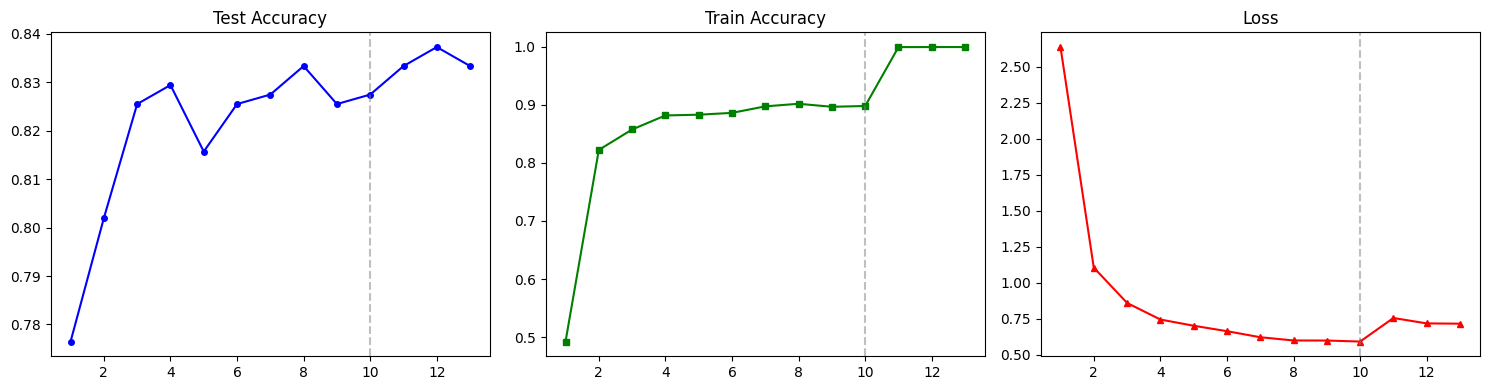

In [10]:
df = pd.read_csv('training_history.csv')
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].plot(df['epoch'], df['test_acc'], 'b-o', markersize=4)
axes[0].axvline(x=EPOCHS_P1, color='gray', linestyle='--', alpha=0.5)
axes[0].set_title('Test Accuracy')
axes[1].plot(df['epoch'], df['train_acc'], 'g-s', markersize=4)
axes[1].axvline(x=EPOCHS_P1, color='gray', linestyle='--', alpha=0.5)
axes[1].set_title('Train Accuracy')
axes[2].plot(df['epoch'], df['loss'], 'r-^', markersize=4)
axes[2].axvline(x=EPOCHS_P1, color='gray', linestyle='--', alpha=0.5)
axes[2].set_title('Loss')
plt.tight_layout()
plt.savefig('training_curves.png', dpi=150)
plt.show()

## 8. Per-Class Analysis

In [11]:
if os.path.exists('best_final.pt'):
    model.load_state_dict(torch.load('best_final.pt'))
elif os.path.exists('best_p1.pt'):
    model.load_state_dict(torch.load('best_p1.pt'))
model.eval()

all_preds, all_true = [], []
with torch.no_grad():
    for videos, video_ids in tqdm(test_loader, desc='Final Eval'):
        videos = videos.to(DEVICE)
        preds = model(videos).logits.argmax(1).cpu().tolist()
        for vid, pred in zip(video_ids.tolist(), preds):
            all_true.append(gt_dict[str(vid)])
            all_preds.append(train_dataset.classes[pred])

overall_acc = accuracy_score(all_true, all_preds)
print(f'\n{"="*60}')
print(f'OVERALL TEST ACCURACY: {overall_acc:.4f} ({overall_acc*100:.2f}%)')
print(f'{"="*60}')

report = classification_report(all_true, all_preds, target_names=train_dataset.classes, digits=4, zero_division=0)
print(report)

with open('per_class_report.txt', 'w') as f:
    f.write(f'Overall: {overall_acc:.4f}\n\n{report}')
print('✓ Saved per_class_report.txt')

Final Eval:   0%|          | 0/26 [00:00<?, ?it/s]


OVERALL TEST ACCURACY: 0.8373 (83.73%)
                precision    recall  f1-score   support

    brush_hair     1.0000    1.0000    1.0000        10
     cartwheel     1.0000    0.9000    0.9474        10
         catch     1.0000    0.8000    0.8889        10
          chew     1.0000    1.0000    1.0000        10
          clap     1.0000    1.0000    1.0000        10
         climb     1.0000    0.9000    0.9474        10
  climb_stairs     0.6667    0.4000    0.5000        10
          dive     1.0000    0.8000    0.8889        10
    draw_sword     0.9091    1.0000    0.9524        10
       dribble     0.9000    0.9000    0.9000        10
         drink     0.8889    0.8000    0.8421        10
           eat     0.7143    1.0000    0.8333        10
    fall_floor     0.8182    0.9000    0.8571        10
       fencing     0.7500    0.9000    0.8182        10
     flic_flac     0.9000    0.9000    0.9000        10
          golf     1.0000    1.0000    1.0000        10
     ha